Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 31)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 31)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 31, 32)       1600000     ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 31, 32)       0           ['embedding[0][0]']          

100/100 [==============================] - 26s 256ms/step - loss: 0.4478 - val_loss: 0.4724
Epoch 49/50
100/100 [==============================] - 26s 262ms/step - loss: 0.4467 - val_loss: 0.4726
Epoch 50/50
100/100 [==============================] - 26s 258ms/step - loss: 0.4454 - val_loss: 0.4735


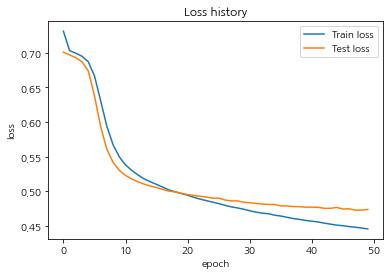

Accuracy = 0.77
log loss = 0.4735


In [1]:
# Quora question pairs : maLSTM 텍스트 유사도 모델
import numpy as np
from sklearn.model_selection  import train_test_split
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import pickle

DATA_PATH = 'C:\\Users\\배진우\\Documents\\multiCampus_TA\\python_data\\quora_question_pairs\\'

# 학습 데이터를 읽어온다.
with open(DATA_PATH + 'qqp.pkl', 'rb') as f:
    q1_data, q2_data, labels, word2idx = pickle.load(f)

# 학습 데이터와 시험 데이터로 나눈다.
q1_train, q1_test, q2_train, q2_test, y_train, y_test = train_test_split(q1_data, q2_data, labels, test_size=0.2)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# maLSTM 모델을 빌드한다.
VOCAB_SIZE = len(word2idx)
EMB_SIZE = 32
HIDDEN_DIM = 10
REG = 0.005

# Question-1, 2 입력용
q1_input = Input(batch_shape=(None, q1_train.shape[1]))
q2_input = Input(batch_shape=(None, q2_train.shape[1]))

# shared embedding
sharedEmb = Embedding(VOCAB_SIZE, EMB_SIZE)

# Question-1 처리용 LSTM
q1_emb = sharedEmb(q1_input)
q1_emb = Dropout(rate=0.5)(q1_emb)
q1_lstm = LSTM(HIDDEN_DIM, dropout=0.5)(q1_emb)

# Question-2 처리용 LSTM
q2_emb = sharedEmb(q2_input)
q2_emb = Dropout(rate=0.5)(q2_emb)
q2_lstm = LSTM(HIDDEN_DIM, dropout=0.5)(q2_emb)

# Question-1, 2의 출력으로 맨하탄 거리를 측정한다.
m_dist = K.exp(-K.sum(K.abs(q1_lstm - q2_lstm), axis=1, keepdims=True))

model = Model([q1_input, q2_input], m_dist)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001))
model.summary()

# 학습
hist = model.fit([q1_train, q2_train], y_train,
                 validation_data = ([q1_test, q2_test], y_test),
                 batch_size = 4096, epochs = 50)

# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# 시험 데이터로 학습 성능을 평가한다
y_prob = model.predict([q1_test, q2_test])
y_pred = np.where(y_prob > 0.5, 1, 0)
accuracy = (y_test == y_pred).mean()
print("Accuracy = %.2f" % (accuracy))

# log loss = cross entropy
log_loss = -(y_test * np.log(y_prob + 1e-8) + 
             (1 - y_test) * np.log(1 - y_prob + 1e-8)).mean()
print("log loss = %.4f" % log_loss)